# TI3145TU Final Assignment 
## Health Insurance 

We hope you enjoy this assignment, good luck!

Student names: Toma Vučinić, Grzegorz Kaminski

Student numbers: 5748070, 5732727

### Imports

In [ ]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
#import seaborn as sns

Traceback (most recent call last):
  File "c:\Users\toma\.vscode\extensions\ms-python.python-2025.2.0-win32-x64\python_files\python_server.py", line 133, in exec_user_input
    retval = callable_(user_input, user_globals)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 10, in <module>
ModuleNotFoundError: No module named 'seaborn'



### Load data

There are missing points in the data we have to fill!


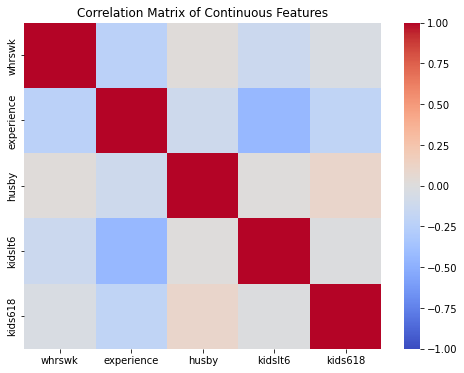

In [3]:
# These are your training samples along with their labels
data = pd.read_csv('health_insurance_train.csv')
data.head()

missing_per_column = data.isna().sum()
if missing_per_column.any():
    print('There are missing points in the data we have to fill!')
else:
    print('Data is full!')

continuous_features = data[['whrswk', 'experience', 'husby', 'kidslt6', 'kids618']].copy()

correlation_matrix = continuous_features.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Continuous Features')
plt.show()

### Creating the Pipelines, filling in the data using SimpleImputer

In [4]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.impute import KNNImputer 
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

X = data.drop(columns=['whrswk']) 
y = data['whrswk']
#count_yes_hispanic = data['hispanic'].value_counts().get("yes", 0)
#print(count_yes_hispanic)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# Numerical and Categorical split
numerical = X.select_dtypes(include=['int64', 'float64']).columns
categorical = X.select_dtypes(exclude=['int64', 'float64']).columns

# Pipeline 1a: Standard Scaling (+ Simple Imputer + Ordinal Encoding)
preprocessor_1a = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline([('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())]), numerical),
        ('categorical', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('encoder', OrdinalEncoder())]), categorical)])

pipeline_1a = Pipeline([('preprocessor', preprocessor_1a)])

# Pipeline 1b: MinMax Scaling + (Simple Imputer + Ordinal Encoding)
preprocessor_1b = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline([('imputer', SimpleImputer(strategy='mean')),('scaler', MinMaxScaler())]), numerical),
        ('categorical', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('encoder', OrdinalEncoder())]), categorical)])

pipeline_1b = Pipeline([('preprocessor', preprocessor_1b)])

# Apply pipelines
X_train_scaled_1a = pipeline_1a.fit_transform(X_train)
X_test_scaled_1a = pipeline_1a.transform(X_test)

X_train_scaled_1b = pipeline_1b.fit_transform(X_train)
X_test_scaled_1b = pipeline_1b.transform(X_test)

# Pipeline 2: Interaction of features

class InteractionFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        X_new['experience'] = pd.to_numeric(X_new['experience'], errors='coerce')
        X_new['education'] = pd.to_numeric(X_new['education'], errors='coerce')
        X_new['husby'] = pd.to_numeric(X_new['husby'], errors='coerce')
        X_new['hhi'] = pd.to_numeric(X_new['hhi'], errors='coerce')
        
        X_new['experience_education'] = X_new['experience'] * X_new['education']
        X_new['husby_hhi'] = X_new['husby'] * X_new['hhi']
        
        columns_to_drop = ['experience', 'education', 'husby', 'hhi']
        X_new = X_new.drop(columns=columns_to_drop, errors='ignore')
        
        return X_new

X_train_interacted = InteractionFeatures().fit_transform(X_train)
X_test_interacted = InteractionFeatures().transform(X_test)
numerical_after_interaction = X_train_interacted.select_dtypes(include=['int64', 'float64']).columns
categorical_after_interaction = X_train_interacted.select_dtypes(exclude=['int64', 'float64']).columns

preprocessor_2 = ColumnTransformer(transformers=[
        ('numerical', Pipeline([('imputer', KNNImputer(n_neighbors = 5)),('scaler', StandardScaler())]), numerical_after_interaction),
        ('categorical', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('encoder', OrdinalEncoder())]), categorical_after_interaction)])

pipeline_2 = Pipeline([('feature_engineering', InteractionFeatures()),('preprocessor', preprocessor_2)]) 

# Apply pipeline 2
X_train_processed_2 = pipeline_2.fit_transform(X_train)
X_test_processed_2 = pipeline_2.transform(X_test)

### Training function for default hyperparameters

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.dummy import DummyRegressor

# Function to train and evaluate the split data with default hyperparameters
def train_and_evaluate(model, X_train, X_test, y_train, y_test, pipeline_name):
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)

    print(f'\n{pipeline_name} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}')
    return model

# KNN Regressor
print('For KNN:')
train_and_evaluate(KNeighborsRegressor(), X_train_scaled_1a, X_test_scaled_1a, y_train, y_test, 'Pipeline 1a')
train_and_evaluate(KNeighborsRegressor(), X_train_scaled_1b, X_test_scaled_1b, y_train, y_test, 'Pipeline 1b')
train_and_evaluate(KNeighborsRegressor(), X_train_processed_2, X_test_processed_2, y_train, y_test, 'Pipeline 2')

# SGD Regressor
print('\nFor SGD:')
train_and_evaluate(SGDRegressor(), X_train_scaled_1a, X_test_scaled_1a, y_train, y_test, 'Pipeline 1a')
train_and_evaluate(SGDRegressor(), X_train_scaled_1b, X_test_scaled_1b, y_train, y_test, 'Pipeline 1b')
train_and_evaluate(SGDRegressor(), X_train_processed_2, X_test_processed_2, y_train, y_test, 'Pipeline 2')

# Random Forest Regressor
print('\nFor Random Forest:')
train_and_evaluate(RandomForestRegressor(), X_train_scaled_1a, X_test_scaled_1a, y_train, y_test, 'Pipeline 1a')
train_and_evaluate(RandomForestRegressor(), X_train_scaled_1b, X_test_scaled_1b, y_train, y_test, 'Pipeline 1b')
train_and_evaluate(RandomForestRegressor(), X_train_processed_2, X_test_processed_2, y_train, y_test, 'Pipeline 2')

#Decision Tree Regressor
print('\nFor decision tree:')
train_and_evaluate(DecisionTreeRegressor(), X_train_scaled_1a, X_test_scaled_1a, y_train, y_test, 'Pipeline 1a')
train_and_evaluate(DecisionTreeRegressor(), X_train_scaled_1b, X_test_scaled_1b, y_train, y_test, 'Pipeline 1b')
train_and_evaluate(DecisionTreeRegressor(), X_train_processed_2, X_test_processed_2, y_train, y_test, 'Pipeline 2')

#Dummy regressor
print('\nThe dummy classifier would predict: ')
dummy = DummyRegressor(strategy = 'mean')
train_and_evaluate(dummy, X_train_scaled_1a, X_test_scaled_1a, y_train, y_test, 'Dummy 1')

For KNN:

Pipeline 1a - Train MAE: 10.1645, Test MAE: 12.2835

Pipeline 1b - Train MAE: 9.8500, Test MAE: 11.9656

Pipeline 2 - Train MAE: 12.3435, Test MAE: 13.6713

For SGD:

Pipeline 1a - Train MAE: 12.4187, Test MAE: 12.1993

Pipeline 1b - Train MAE: 12.4307, Test MAE: 12.1802

Pipeline 2 - Train MAE: 12.8201, Test MAE: 12.5287

For Random Forest:

Pipeline 1a - Train MAE: 4.4156, Test MAE: 11.5267

Pipeline 1b - Train MAE: 4.4276, Test MAE: 11.5171

Pipeline 2 - Train MAE: 11.5155, Test MAE: 12.7293

For decision tree:

Pipeline 1a - Train MAE: 0.2054, Test MAE: 13.7046

Pipeline 1b - Train MAE: 0.2054, Test MAE: 13.9259

Pipeline 2 - Train MAE: 11.2704, Test MAE: 12.8552

The dummy classifier would predict: 

Dummy 1 - Train MAE: 16.9578, Test MAE: 17.0064


DummyRegressor()

### Nested CV for finding the best performing model and its hyperparameters

In [6]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

model_configs = {
    "SGD": {
        "model": SGDRegressor(max_iter = 5000, tol = 1e-3, warm_start = True),
        "params": {'alpha': np.logspace(-6, -1, 10),"eta0": np.linspace(0.001, 1, 10)}},
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {"n_neighbors": [3, 5, 7, 9, 11],"leaf_size": [10, 20, 30, 40],"p": [1, 2]}},
     "RandomForest": {
         "model": RandomForestRegressor(),
         "params": {"n_estimators": [50, 100, 200],"max_depth": [5, 10, 20, None],"min_samples_split": [2, 5, 10],"min_samples_leaf": [1, 2, 4]}},
    "DecisionTree": {
        "model": DecisionTreeRegressor(),
        "params": {"max_depth": [5, 10, 15, 20, None],"min_samples_split": [2, 5, 10, 15],"min_samples_leaf": [1, 2, 5, 10]}},
    "Dummy": {
        "model": DummyRegressor(strategy="mean"),
        "params": {}}}

def nested_cross_val(model_config, pipeline, X, y, outer_splits=3, inner_splits=3):
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
    outer_maes = []
    best_outer_mae = float("inf")
    best_model = None
    best_hyperparams = None

    for train_idx, test_idx in outer_cv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

        model_pipeline = Pipeline([('pipeline', pipeline), ('model', model_config['model'])])
        grid_search = GridSearchCV(
            model_pipeline, param_grid={f"model__{k}": v for k, v in model_config['params'].items()}, cv=inner_splits, scoring="neg_mean_absolute_error",n_jobs=-1)

        grid_search.fit(X_train_cv, y_train_cv)
        best_inner_model = grid_search.best_estimator_
        best_inner_params = grid_search.best_params_

        # Evaluate on the outer test set and record MAE
        y_pred = best_inner_model.predict(X_test_cv)
        test_mae = mean_absolute_error(y_test_cv, y_pred)
        outer_maes.append(test_mae)

        print(f"Test MAE for this fold: {test_mae:.4f}")
        if test_mae < best_outer_mae:
            best_outer_mae = test_mae
            best_model = best_inner_model
            best_hyperparams = best_inner_params

    print(f"\nLowest Test MAE: {best_outer_mae:.4f}")
    print(f"Best hyperparameters: {best_hyperparams}")

    return best_model

print('For SGD: ')
best_model_sgd = nested_cross_val(model_configs['SGD'], pipeline_1b, X, y)
print('\n For Random Forest: ')
best_model_rf = nested_cross_val(model_configs['RandomForest'], pipeline_1b, X, y)
print('\n For KNN: ')
best_model_knn = nested_cross_val(model_configs['KNN'], pipeline_1b, X, y)
print('\n For Decision Tree: ')
best_model_dt = nested_cross_val(model_configs['DecisionTree'], pipeline_2, X, y)

For SGD: 
Test MAE for this fold: 12.1918
Test MAE for this fold: 12.5623
Test MAE for this fold: 12.3834

Lowest Test MAE: 12.1918
Best hyperparameters: {'model__alpha': 4.6415888336127825e-05, 'model__eta0': 0.001}

 For Random Forest: 
Test MAE for this fold: 11.2220
Test MAE for this fold: 11.6305
Test MAE for this fold: 11.2527

Lowest Test MAE: 11.2220
Best hyperparameters: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 200}

 For KNN: 
Test MAE for this fold: 11.8134
Test MAE for this fold: 12.5684
Test MAE for this fold: 11.7588

Lowest Test MAE: 11.7588
Best hyperparameters: {'model__leaf_size': 40, 'model__n_neighbors': 9, 'model__p': 1}

 For Decision Tree: 
Test MAE for this fold: 12.5078
Test MAE for this fold: 12.8210
Test MAE for this fold: 12.5871

Lowest Test MAE: 12.5078
Best hyperparameters: {'model__max_depth': 5, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}


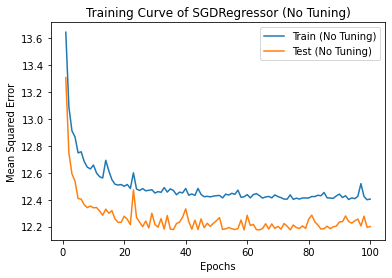

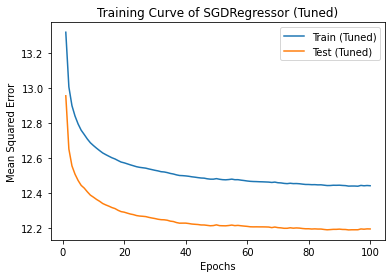

12.195923096759984
12.200590154013666


In [7]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

n_epochs = 100
train_errors = []
test_errors = []
train_errors_T = []
test_errors_T = []

SGD_noTuni = SGDRegressor(warm_start = True) 
SGD_Tun = SGDRegressor(alpha=1e-05, eta0=0.001, max_iter=5000, warm_start=True, learning_rate = 'invscaling', power_t = 0.5)

for epoch in range(n_epochs):
    SGD_noTuni.partial_fit(X_train_scaled_1b, y_train)
    y_train_predict = SGD_noTuni.predict(X_train_scaled_1b)
    y_test_predict = SGD_noTuni.predict(X_test_scaled_1b)

    train_errors.append(mean_absolute_error(y_train, y_train_predict))
    test_errors.append(mean_absolute_error(y_test, y_test_predict))

    SGD_Tun.fit(X_train_scaled_1b, y_train)
    y_train_predict_T = SGD_Tun.predict(X_train_scaled_1b)
    y_test_predict_T = SGD_Tun.predict(X_test_scaled_1b)

    train_errors_T.append(mean_absolute_error(y_train, y_train_predict_T))
    test_errors_T.append(mean_absolute_error(y_test, y_test_predict_T))

# Plotting the training curve for non-tuned model
plt.plot(range(1, n_epochs + 1), train_errors, label="Train (No Tuning)")
plt.plot(range(1, n_epochs + 1), test_errors, label="Test (No Tuning)")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training Curve of SGDRegressor (No Tuning)")
plt.legend()
plt.show()

#Plotting the training curve for tuned model
plt.plot(range(1, n_epochs + 1), train_errors_T, label="Train (Tuned)")
plt.plot(range(1, n_epochs + 1), test_errors_T, label="Test (Tuned)")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training Curve of SGDRegressor (Tuned)")
plt.legend()
plt.show()
print(test_errors_T[-1])
print(test_errors[-1])

### Evaluation of performance

In [ ]:
print('For SGD: ')
model_sgd = train_and_evaluate(SGDRegressor(), X_train_scaled_1b, X_test_scaled_1b, y_train, y_test, 'Pipeline 1b')
untuned_model_sgd_predictions = model_sgd.predict(X_test_scaled_1b)
tuned_model_sgd_predictions = SGD_Tun.predict(X_test_scaled_1b)
untuned_model_sgd_mae = mean_absolute_error(y_test, untuned_model_sgd_predictions)
tuned_model_sgd_mae = mean_absolute_error(y_test, tuned_model_sgd_predictions)
print('Before tuning: ', untuned_model_sgd_mae, ', After tuning: ', tuned_model_sgd_mae)

print('\n For KNN: ')
model_knn = train_and_evaluate(KNeighborsRegressor(), X_train_scaled_1b, X_test_scaled_1b, y_train, y_test, 'Pipeline 1b')
untuned_model_knn_predictions = model_knn.predict(X_test_scaled_1b)
tuned_model_knn_predictions = best_model_knn[1].predict(X_test_scaled_1b)
untuned_model_knn_mae = mean_absolute_error(y_test, untuned_model_knn_predictions)
tuned_model_knn_mae = mean_absolute_error(y_test, tuned_model_knn_predictions)
print('Before tuning: ', untuned_model_knn_mae, ', After tuning: ', tuned_model_knn_mae)

print('\nFor Random Forest: ')
model_rf = train_and_evaluate(RandomForestRegressor(), X_train_scaled_1b, X_test_scaled_1b, y_train, y_test, 'Pipeline 1b')
untuned_model_rf_predictions = model_rf.predict(X_test_scaled_1b)
tuned_model_rf_predictions = best_model_rf[1].predict(X_test_scaled_1b)
untuned_model_rf_mae = mean_absolute_error(y_test, untuned_model_rf_predictions)
tuned_model_rf_mae = mean_absolute_error(y_test, tuned_model_rf_predictions)
print('Before tuning: ', untuned_model_rf_mae, ', After tuning: ', tuned_model_rf_mae)

print('\nFor Decision Trees: ')
model_dt = train_and_evaluate(DecisionTreeRegressor(), X_train_processed_2, X_test_processed_2, y_train, y_test, 'Pipeline 2')
untuned_model_dt_predictions = model_dt.predict(X_test_processed_2)
tuned_model_dt_predictions = best_model_dt[1].predict(X_test_processed_2)
untuned_model_dt_mae = mean_absolute_error(y_test, untuned_model_dt_predictions)
tuned_model_dt_mae = mean_absolute_error(y_test, tuned_model_dt_predictions)
print('Before tuning: ', untuned_model_dt_mae, ', After tuning: ', tuned_model_dt_mae)

For SGD: 

Pipeline 1b - Train MAE: 12.4187, Test MAE: 12.2194
Before tuning:  12.21944734706209 , After tuning:  12.195923096759984

 For KNN: 

Pipeline 1b - Train MAE: 9.8500, Test MAE: 11.9656
Before tuning:  11.965566886622675 , After tuning:  10.742184896354063

For Random Forest: 

Pipeline 1b - Train MAE: 4.4565, Test MAE: 11.4904
Before tuning:  11.490436455998843 , After tuning:  11.221996584091293

For Decision Trees: 

Pipeline 2 - Train MAE: 11.2704, Test MAE: 12.8492
Before tuning:  12.849199302963557 , After tuning:  12.507849208578168


### Autograder

In the autograder you will need to provide two things: 1) estimate of the MAE of your model on unseen data, 2) the predictions on the autograder data. For the autograder data we only provide the features and not the regression targets. Thus, you cannot compute the MAE on this data yourself - you need to estimate that with the data provided above. 

In [ ]:
data_autograder = pd.read_csv('health_insurance_autograde.csv')
data_autograder.head()

In [ ]:
# TODO Replace this with your own estimate of the MAE of your best model
estimate_MAE_on_new_data = np.array([11.21])

# TODO Replace this with the predictions of your best model
# via e.g. prediction = model.predict(data_autograder)
data_autograder_scaled = best_model_rf[0].transform(data_autograder)
predictions_autograder_data = best_model_rf[1].predict(data_autograder_scaled)

# Upload this file to the Vocareum autograder:
result = np.append(estimate_MAE_on_new_data, predictions_autograder_data)
pd.DataFrame(result).to_csv("autograder_project_ultimo.txt", index=False, header=False)